## Price prediction in public procurement

---

### Team Members
<div style="font-family: Arial, sans-serif;">
<table style="width: 50%; margin: auto; border-collapse: collapse; border: 1px solid black;">
  <thead>
    <tr style="background-color: #f2f2f2; border: 1px solid black;">
      <th style="padding: 8px; text-align: left;">Full Name</th>
      <th style="padding: 8px; text-align: left;">ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px; text-align: left;">Roman Savoskin</td>
      <td style="padding: 8px; text-align: left;">24MD0378</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">Amina Duisembayeva</td>
      <td style="padding: 8px; text-align: left;">24MD0349</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">Dastan Alibekov</td>
      <td style="padding: 8px; text-align: left;">24MD0339</td>
    </tr>
  </tbody>
</table>
</div>

---

### Dataset
We upload all subparts of prepared dataset before filtering, aggregation and joins into [Teams Drive](https://kbtuedu-my.sharepoint.com/:f:/g/personal/rom_savoskin_kbtu_kz/EuX15EEtYyVGlw_kWTj7y70BxXid0uH3v25O_8OhvVNTYg?e=3H6DBP) due to bigger storage size for students  
Our final dataset could be found on [Google Drive](https://drive.google.com/file/d/16FiXTS7I1beJj7HOs6U903eeniAA9iMD/view?usp=drive_link)


### **Source Code**
The source code for this project is hosted on [GitHub](https://github.com/savoskin0502/public-procurement-optimization)


#### **Directory Structure**
- **/migrations/** - includes database migration scripts using `flyway` to prepare database with all required tables and scripts. We found it easier to prepare our initial dataset using SQL rathen than python and `.csv`. `V__` - versioned migrations, execution order matter. `R__` - repeatable migrations, will be executed after `versioned` migrations.
- **/api/src/** - contains the implementation of the API logic using streamlit, including gathering information by lot number from [goszakup](https://goszakup.gov.kz/) and price prediction using `XgBoost` and `Multi Armed Bandits`
- **/.devcontainer/** - config file to deploy our service and make it accessible by dns [https://pricing-kbtu.streamlit.app/](https://pricing-kbtu.streamlit.app/)
- **/parser/** - scripts to extract data from [goszakup](https://goszakup.gov.kz/) using [graphql](https://ows.goszakup.gov.kz/help/v3/schema/query.doc.html) that we will upload further to [Teams Drive](https://kbtuedu-my.sharepoint.com/:f:/g/personal/rom_savoskin_kbtu_kz/EuX15EEtYyVGlw_kWTj7y70BxXid0uH3v25O_8OhvVNTYg?e=3H6DBP)


### **How to Run**
1. **Please, install `Makefile`**

2. **You can run any target you wish from `Makefile`**
    ```bash
    make run-api # will run streamlit API locally
    ```


#### 


In [1]:
import os
import gdown

file_name = "dataset.csv"
file_id = "16FiXTS7I1beJj7HOs6U903eeniAA9iMD"
drive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(file_name):
    print(f"{file_name} does not exist. Downloading...")
    gdown.download(drive_url, file_name, quiet=False)
    print(f"{file_name} has been downloaded successfully.")
else:
    print(f"{file_name} already exists.")

dataset.csv does not exist. Downloading...


Downloading...
From (original): https://drive.google.com/uc?id=16FiXTS7I1beJj7HOs6U903eeniAA9iMD
From (redirected): https://drive.google.com/uc?id=16FiXTS7I1beJj7HOs6U903eeniAA9iMD&confirm=t&uuid=ed06feb6-88ab-474a-abd3-7504d65a5c45
To: /Users/roman/Desktop/ms/public-procurement-optimization/dataset.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.98G/3.98G [14:55<00:00, 4.44MB/s]

dataset.csv has been downloaded successfully.


In [54]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format

In [6]:
data = pd.read_csv(
    file_name,
    delimiter=';',
    dtype=str,
    usecols=[
        "lot_id",
        "fw_total_price_wdiscount",
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount",

        # integers
        "total_count",        
        "ad_lots_count",

        # binary
        "is_union_lots",
        "is_dumping",
        "is_consulting_services",
        "is_disable_person_advertisement",
        "ad_disable_person_id",
        "ad_purchase_type_id",
        "participant_is_have_website",
        "participant_is_quazi",
        "participant_is_national_company",
        "participant_is_association_with_disabilities",
        "participant_is_supplier",
        "participant_is_state_monopoly",
        "participant_is_natural_monopoly",
        "participant_is_small_employer",
        "participant_is_single_org",
        
        # categorical
        "lot_status_id",
        "plan_trade_method_id",
        "psd_sign",
        "single_org_sign",
        "is_light_industry",
        "is_construction_work",
        "ad_trade_method_id",
        "ad_subject_type_id",
        "ad_trade_type_id",
        "ad_single_org_sign",
        "ad_is_light_industry",
        "ad_is_construction_work",
        "participant_creation_date",
        "participant_registration_year",
        "participant_krp_code",
        "participant_oked_list",
        "participant_kse_code",

        # additional
        "ad_start_date",
        "ad_repeat_start_date",
        "ad_end_date",
        "ad_repeat_end_date",
        "ad_publish_date",

        "ad_fin_years",
        "ad_katos",
        "participant_registration_date",
        "participant_kato_list",
        "participant_kopf_code",
        "participant_branches",
        "participant_parent_company",
    ]
)
data.head()

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_is_supplier,participant_krp_code,participant_branches,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org
0,29526032,4160393.3600,4186892.6800,360,0,1,4907281.6200,1,188,18,...,1,0,NaN,NaN,36000,5,0,1,0,0
1,29525894,13900.0000,15900.0000,360,0,100,20000.0000,0,3,0,...,1,0,NaN,NaN,85100,5,0,1,1,0
2,29524214,209999.0000,249000.0000,360,0,1,250000.0000,0,3,0,...,0,0,NaN,NaN,84113,5,0,0,0,0
3,29520431,2400.0000,2790.0000,360,0,30,3000.0000,0,3,0,...,0,0,NaN,NaN,84114,5,0,0,0,0
4,29415829,169000.0000,171600.0000,360,0,5,214285.7000,0,3,0,...,1,0,NaN,NaN,85520,5,0,0,1,0


<div style="font-family: Arial, sans-serif; text-align: center;">
    
## Columns that we didn't include in our dataset, despite the fact that they're present in `.csv`

<table style="width: 50%; margin: auto; bo rder-collapse: collapse; border: 1px solid black;">
  <thead>
    <tr style="background-color: #f2f2f2; border: 1px solid black;">
      <th style="padding: 8px; text-align: left;">Column</th>
      <th style="padding: 8px; text-align: left;">Column description</th>
      <th style="padding: 8px; text-align: left;">Why was excluded</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px; text-align: left;">customer_id</td>
      <td style="padding: 8px; text-align: left;">ID of the customer (those who organize tender and wan't to buy something)</td>
      <td style="padding: 8px; text-align: left;">Too big variability relative to the number of lots, so we decided to use the attributes of the customer but not their identifier</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">fact_trade_method_id</td>
      <td style="padding: 8px; text-align: left;">Код фактического способа закупки</td>
      <td style="padding: 8px; text-align: left;">До завершения закупки известен только плановый способ закупки</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">ad_itogi_date_public</td>
      <td style="padding: 8px; text-align: left;">Дата публикации итогов тендера</td>
      <td style="padding: 8px; text-align: left;">Известно только после окончания закупки</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">advertisement_status_id</td>
      <td style="padding: 8px; text-align: left;">Статус закупки</td>
      <td style="padding: 8px; text-align: left;">На этапе фильтрации SQL оставили только завершенные закупки, те которые имею `id = 350`. Т.к результат для незавершенных закупок еще неизвестен, то и для обучения модели мы такие результаты, без известного Y использовать не можем</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">participant_country</td>
      <td style="padding: 8px; text-align: left;">Страна участника тендера (с точки зрения закупщика)</td>
      <td style="padding: 8px; text-align: left;">Было только одно значение, "Казахстан"</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">participant_is_*</td>
      <td style="padding: 8px; text-align: left;">Является ли закупщик ... </td>
      <td style="padding: 8px; text-align: left;">Почему-то эти атрибуты особо не заполнялись. Буквально 10-15 строк заполненных из 6 миллионов. Ответ на этот вопрос поддержка портала Госзакупок детально не раскрыла</td>
    </tr>
  </tbody>
</table>
</div>

Рассматривая наши данные с точки зрения же частоты и заполнения других атрибутов, мы видим примерно следующее

In [19]:
print("=" * 80)
print(f"\033[1m\033[94mShape of the DataFrame:\033[0m")
print(f"  \033[92mRows:\033[0m {data.shape[0]}  \033[92mColumns:\033[0m {data.shape[1]}")
print("=" * 80)

print(f"\033[1m\033[94mSummary of Missing and Filled Values (Ordered by Missing Frequency):\033[0m")
missing = data.isnull().sum()
filled = data.shape[0] - missing  # Calculate filled values
fill_miss_summary = pd.DataFrame({
    'Missing Values': missing[missing > 0].sort_values(ascending=False),
    'Filled Values': filled[missing > 0].sort_values(ascending=False)
})

print(fill_miss_summary.sort_values(by='Missing Values', ascending=False).to_string())
print("=" * 80)

Shape of the DataFrame:
  Rows: 6034221  Columns: 51
Summary of Missing and Filled Values (Ordered by Missing Frequency):
                                              Missing Values  Filled Values
participant_parent_company                           5864322         169899
ad_repeat_end_date                                   5847484         186737
ad_repeat_start_date                                 5847484         186737
participant_branches                                 5761800         272421
is_construction_work                                 4294274        1739947
is_disable_person_advertisement                      4294274        1739947
is_light_industry                                    4294274        1739947
single_org_sign                                      4294274        1739947
plan_trade_method_id                                 4294274        1739947
sw_total_price_wdiscount                              355231        5678990
participant_kopf_code                     

Скорее всего все что связано с `participant_` - это исключения из правил (301 пустая запись), для упрощения можем исключить. Потенциально все поля в таблице выше связанные с `participant_` должны быть заполнены, ведь это обязательная информация которая заполняется при регистрации закупщика.

Детальное изучение атрибута `single_org_sign` показало что оно является аналогом атрибута `participant_is_single_org`, только если первое извлекается из закупки, то второе из закупщика.

Пустые `sw_total_price_wdiscount` объясняются тем что есть закупки с кол-вом поставщиков-участников равным 1-ому. В таком случае можем подставить вместо `sw_total_price_wdiscount` значение из поля `total_amount`, т.е изначальную цену лота по которой был готов купить закупщик. Это допустимо, ведь победитель может поднять свою цену до этой изначальной цены и всеравно выиграть, ведь никто кроме него в тендере не участвовал.

`ad_repeat_start_date` и `ad_repeat_end_date` это даты начала и окончания закупки в случае если первая попытка тендера была неудачной ( не удалось по тем или иным причинам, например заявки никто не подал ). Исключать смысла нет, лучше мы это обыграем и используем совместно со `start_date` и `end_date`, ведь эти поля - их продолжения.

Вопрос насчет `participant_parent_company` и `participant_branches` открыт.
Заведем пока квантили чтобы далее изучить наши данные с точки зрения распределения, исключить аутлайеры ( при необходимости ).

In [23]:
quantiles = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]

Т.к изначально мы загрузили наши данные как объекты чтобы исключить дурное влияние pandas-а на конвертацию типов - давайте конвертируем 
цифры в нужный тип данных

In [26]:
for numeric_field in (
    "fw_total_price_wdiscount",
    "sw_total_price_wdiscount",
    "ad_total_sum",
    "total_amount",

    "total_count",        
    "ad_lots_count",
):
    data[numeric_field] = pd.to_numeric(data[numeric_field])

Т.к нам нужны не столько состоявшиеся закупки, сколько состоявшиеся лоты ( ведь предикты делать мы будем именно в рамках них ) - исключим те лоты 
закупка по которым не состоялась. ( не обязательно в случае если закупка успешна - все лоты по ней были выкуплены )

In [29]:
data = data[data.lot_status_id == '360'] # 4878 rows

# Продублирую информацию которую выше писали касательно этого поля
# Пустые sw_total_price_wdiscount объясняются тем что есть закупки с кол-вом поставщиков-участников равным 1-ому.
# В таком случае можем подставить вместо sw_total_price_wdiscount значение из поля total_amount, т.е изначальную цену лота по которой был готов
# купить закупщик. Это допустимо, ведь победитель может поднять свою цену до этой изначальной цены и всеравно выиграть, ведь никто кроме него в 
# тендере не участвовал.
data.loc[data.sw_total_price_wdiscount.isna(), "sw_total_price_wdiscount"] = data.loc[data.sw_total_price_wdiscount.isna(), "total_amount"]

В процессе анализа выяснилось что на портале имеются закупки по которым спутались кол-во и цена за один товар, полная цена.
Фактически это влияет на нашу таргет переменную `sw_total_price_wdiscount`, ведь она становится некорректной, получая значения ниже первого победителя

Мы посмотрели и таких закупок было немного за 7 лет, поэтому решили их исключить.

In [34]:
data = data[~(data.sw_total_price_wdiscount < data.fw_total_price_wdiscount)] # 1163 rows

Учитывая тот факт что мы не планируем в данной работе делать вклад в благотворительность, а хотим помочь заработать деньги - 
нам нет необходимости рассматривать лоты с совсем низкой стоимостью. Оценим если есть такие и уберем совсем невыгодные

In [41]:
pd.DataFrame({
    "Quantile": quantiles,
    "Upper Bound Winner Bid": data.fw_total_price_wdiscount.quantile(quantiles)
})

,Quantile,Upper Bound Winner Bid
0.00,0.00,0.00
0.01,0.01,0.00
0.05,0.05,0.00
0.10,0.10,"1,440.00"
0.25,0.25,"9,200.00"
0.50,0.50,"42,000.00"
0.75,0.75,"202,455.00"
0.90,0.90,"1,006,800.00"
0.95,0.95,"3,007,000.00"
0.99,0.99,"24,306,096.39"


Учитывая общие объемы, 1440 тенге, как и 0, выглядит тоже небольшой ценой.

Допустим что все что входит в этот квантиль - благотворительность, на которую мы не готовы, пока, подписываться. 

По крайней мере - если закупщик настроен решительно заняться благотворительностью, значит знает какую цену
указать и наша модель ему пользы не принесет.

In [43]:
data = data[~(data.fw_total_price_wdiscount <= data.fw_total_price_wdiscount.quantile(0.10))]

Порой встречаются индивиды которые обходят все возможные правила окольными путями - к таким можно отнести и тех кто расходует бюджет сверх-запланированного и
с обходом регламентов ( например, в случае закупок - старый тендер необходимо закрыть и открыть новый, делается быстро ).

На портале же мы нашли тех кто умудрился поставить товары заказчику по цене ВЫШЕ запланированной правительством.
Мы не думаем что такое прокатит для любого поставщика. Как таких выявить - точно не знаем, каких-то фиксированных организаций не увидели.
Благо, таких было немного.

In [45]:
data = data[~(data.fw_total_price_wdiscount > data.total_amount)] # 10311

Кроме тех кто занимается благотворительностью, возможно есть и те кто сбрасывают очень сильно цену относительно изначальной. Как выявить таких?
Довольно просто, можем соотношения по квантилям оценить между изначальной ценой лота и победителя

In [47]:
pd.DataFrame({
    "Quantile": quantiles,
    "(total_amount / fw_total_price_wdiscount)": (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)
})

,Quantile,(total_amount / fw_total_price_wdiscount)
0.00,0.00,1.00
0.01,0.01,1.00
0.05,0.05,1.00
0.10,0.10,1.03
0.25,0.25,1.12
0.50,0.50,1.34
0.75,0.75,1.69
0.90,0.90,2.12
0.95,0.95,2.47
0.99,0.99,3.65


Сбрасывать цену в 11 тыс раз это, конечно, сильно. Нам такие не нужны, они только и сделают что приведут к сильному разбросу в residuals

In [49]:
data = data[~((data['total_amount'] / data['fw_total_price_wdiscount']) > (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(0.99))] # 54142 row

Кроме того были и закупки с которыми мы не совсем понимали как лучше работать, это те по которым изначальная цена, цена первого победителя и цена
второго победителя одинаковы. 

Мы предполагаем что такие закупки лучше отделить на основе каких-либо условий и в случае если человек будет участвовать в такой закупке - давать ему
в качестве рекомендуемой цены изначальную цену лота.

In [52]:
data = data[~(data.fw_total_price_wdiscount == data.total_amount)] # 194170 rows

Завершив с базовым, теперь можно углубиться и в изучение атрибутов. Наиболее интересующие нас в первую очередь это, конечно же, те которые связаны с ценой.

В частности `sw_total_price_wdiscount` - переменная которая будет использоваться в качестве таргета, `total_amount` - изначальная цена лота от которой
и строится предложение.


Давайте построим распределение и оценим его. Первичный вывод - очень сильный разброс значений, потенциально - плохо и никогда ни к чему хорошему на нашем
опыте еще не приводило. В нашем случае всеравно протестировали и увидели что наша модель ошибается в 91% случаев, а R^2 менее 1%. 

Обычно в таких случаях можно поиграться с распределениями, но на графике очевидно видно доминирование малых значений - возможно зайдет логарифм.
Мы попробовали и это довольно сильно улучшило картинку. 

Чтобы сравнить с Normal нанесли значения из нормального распределения на график на который нанесли логарифм. Результат нас порадовал, по итогу это же преобразование и применим на наших данных.

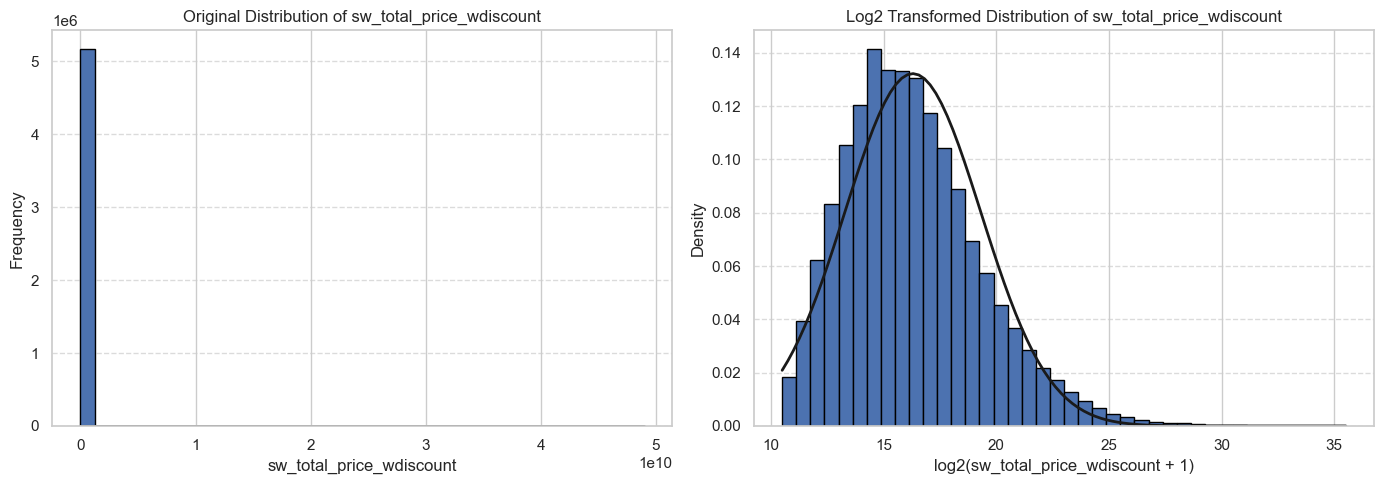

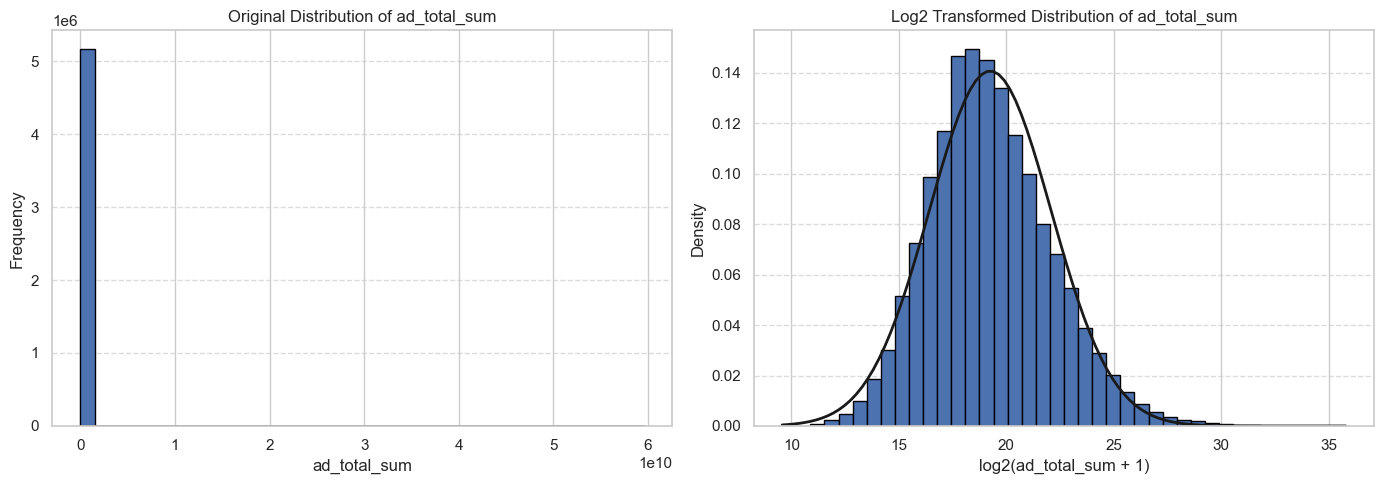

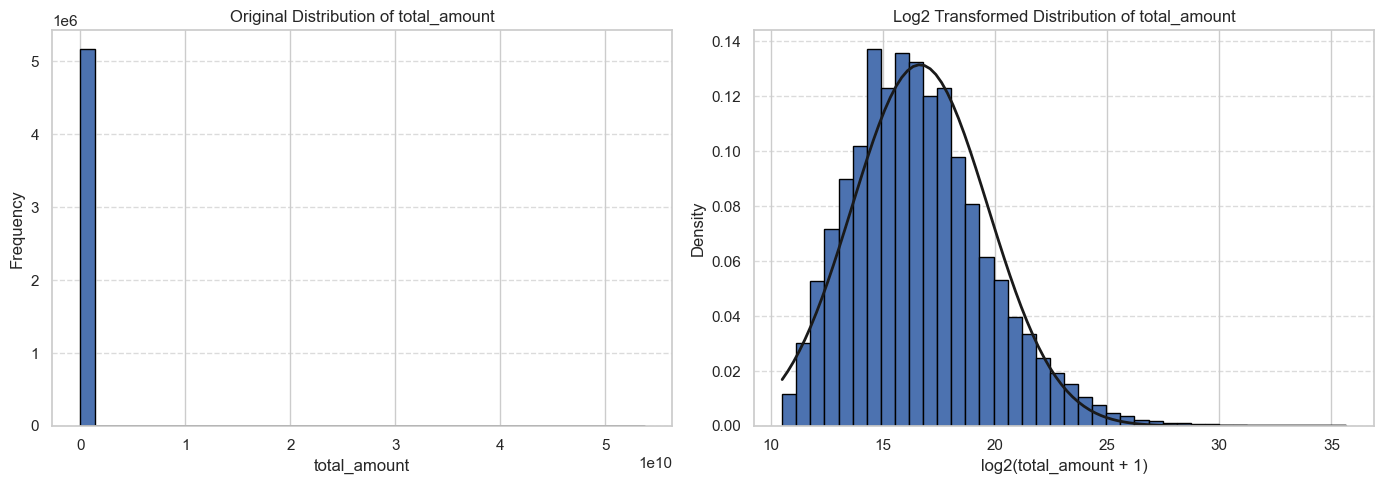

In [74]:
for col in ["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(data[col], bins=40, edgecolor="black")

    mu, std = norm.fit(data[col])
    x = np.linspace(data[col].min(), data[col].max(), 100)
    p = norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'k', linewidth=2)

    ax[0].set_title(f"Original Distribution of {col}")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frequency")
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    log2_data = np.log2(data[col] + 1)
    ax[1].hist(log2_data, bins=40, edgecolor="black", density=True)
    mu, std = norm.fit(log2_data)
    x = np.linspace(log2_data.min(), log2_data.max(), 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title(f"Log2 Transformed Distribution of {col}")
    ax[1].set_xlabel(f"log2({col} + 1)")
    ax[1].set_ylabel("Density")
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

Что нас сразу же порадовало и бросилось в глаза, так это сильная потенциальная корреляция между sw_total_price_wdiscount и total_amount (наш Y).
А вот ad_total_amount смещено вправо ( что логично, ведь закупка состоит из множества лотов ).

Давайте убедимся в этом и подтвердим что, действительно, между нашей предикт переменной и изначальной суммой лота есть связь, возможно линейная ( раз мы сразу тут же и видим все )

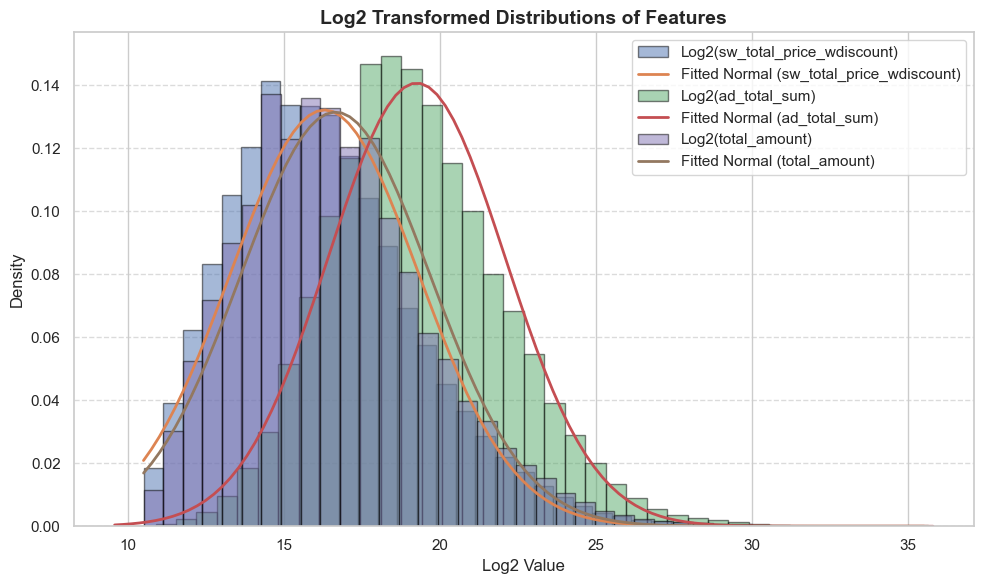

In [90]:
plt.figure(figsize=(10, 6))

for col in ["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]:
    log2_data = np.log2(data[col] + 1)

    plt.hist(log2_data, bins=40, alpha=0.5, density=True, edgecolor='black', label=f'Log2({col})')

    mu, std = norm.fit(log2_data)
    x = np.linspace(log2_data.min(), log2_data.max(), 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2, label=f'Fitted Normal ({col})')

plt.title("Log2 Transformed Distributions of Features", fontsize=14, weight='bold')
plt.xlabel("Log2 Value")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Выглядит хорошо, осталось понять нужно ли нам оставить обе переменные (`ad_total_sum` и `total_amount`), или же может быть достаточно одной.

Давайте не будем содействовать появлению мультиколлинеарности и сразу же это проверим (конечно, мы можем понадеяться на некоторые алгоритмы которые относительно устойчивы к ней по типу бустингов, однако прогонять мы также будем и на линейной регрессии, учитывая потенциальную линейную связь между основными переменными )

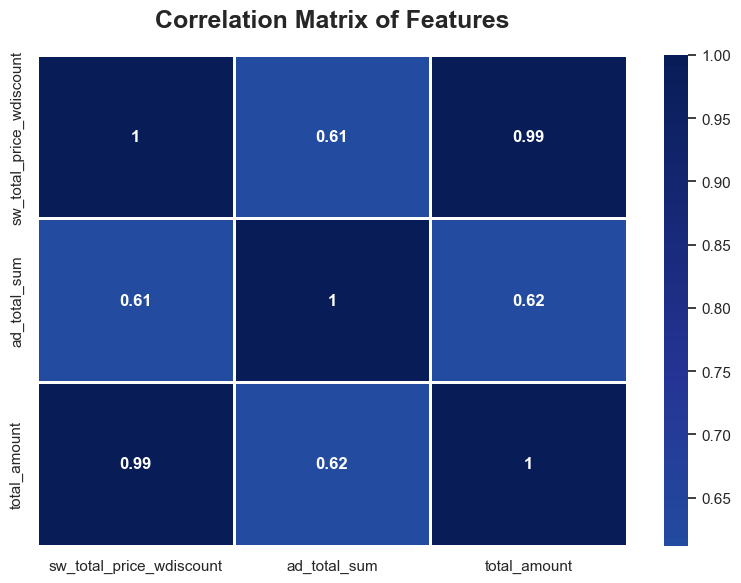

In [91]:
sns.set_theme(style="whitegrid", font_scale=1.0)

# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    # data[["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]].corr(),
    np.log2(data[["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]].replace(0, np.nan)).dropna().corr(),
    annot=True,
    cmap='YlGnBu',
    center=0,
    linewidths=1,
    linecolor='white',
    annot_kws={"size": 12, "weight": "bold"}
)

plt.title('Correlation Matrix of Features', fontsize=18, weight='bold', pad=20)

plt.tight_layout()
plt.show()

Отсюда можно сделать два основных вывода
1. Действительно, связь между Y (`sw_total_price_wdiscount`) и `total_amount` крайне сильная
2. При этом сильная связь между `total_amount` и `ad_total_sum`, что может привести к мультиколлинеарности

Учитывая что связь с предиктором сильнее у `total_amount`, этот атрибут мы и оставим

Продолжить подготовку атрибутов предлагаем с дат, в частности
- ad_start_date - дата начала тендера
- ad_end_date - дата окончания тендера
- ad_repeat_start_date - дата повторного начала тендера
- ad_repeat_end_date - дата повторного завершения тендера

С датами напрямую мы работать не можем в модели, однако вполне можем подготовить другие атрибуты, которые дают ответ на следующие два вопроса
- А влияет ли продолжительность тендера на цену победителя?
- А влияет ли информация о том, сразу эта закупка оказалась успешной или нет на цену победителя?

Следуя такой логике, можем подготовить атрибуты, беря в расчет и те закупки которые завершились день в день
$$
\text{duration} = \text{ad\_end\_date} - \text{ad\_start\_date} + 1
$$

и по аналогии

$$
\text{repeat\_duration} = \text{ad\_repeat\_end\_date} - \text{ad\_repeat\_start\_date} + 1
$$


In [147]:
data['ad_start_date'] = pd.to_datetime(data['ad_start_date'])
data['ad_repeat_start_date'] = pd.to_datetime(data['ad_repeat_start_date'])
data['ad_end_date'] = pd.to_datetime(data['ad_end_date'])
data['ad_repeat_end_date'] = pd.to_datetime(data['ad_repeat_end_date'])

In [148]:
data['duration'] = (data['ad_end_date'] - data['ad_start_date']).dt.days + 1
data['repeat_duration'] = (data['ad_repeat_end_date'] - data['ad_repeat_start_date']).dt.days + 1

В ходе изучения данных мы также выявили некорректно заполненные с точки зрения дат закупки, их оказалось 18 за 7 лет, решили исключить.

In [149]:
data = data[~(data.ad_start_date > data.ad_end_date)] # 18 rows

Немного оценив квантили, можно примерно понять в каком диапазоне закупки пользуются спросом и что логически было бы корректнее разделить их на диапазоны, нежели оставить высокую вариабельность которая может не иметь значения ( например, разница 28 или 29 дней наврядли имеет смысл, ведь при заключении контрактов часто ориентируются на сроки 7, 15, 30, 60, 90 и т.д ). Предлагаем оценить квантили и принять на основе этого решение о том какие интервалы выбрать

Таким образом, заведем две переменные, которые назовем `duration_power` и `repeat_duration_power`, предварительно изучив распределения и поняв на какие диапазоны разделять. Правда, учитывая соотношение кол-ва NaN для `repeat_duration`, возможно будет лучшей идеей создать для `repeat_duration` бинарную переменную `is_repeated_ad` которая отвечает на вопрос является ли эта закупка повторной или нет.

In [174]:
data["duration"].quantile([0.0, 0.25, 0.5, 0.75, 0.78, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999, 1.0])

0.00    1.00
0.25    8.00
0.50    8.00
0.75    8.00
0.78    9.00
0.80    9.00
0.90   11.00
0.95   16.00
0.99   18.00
1.00   30.00
1.00   45.00
1.00   56.00
1.00   92.00
Name: duration, dtype: float64

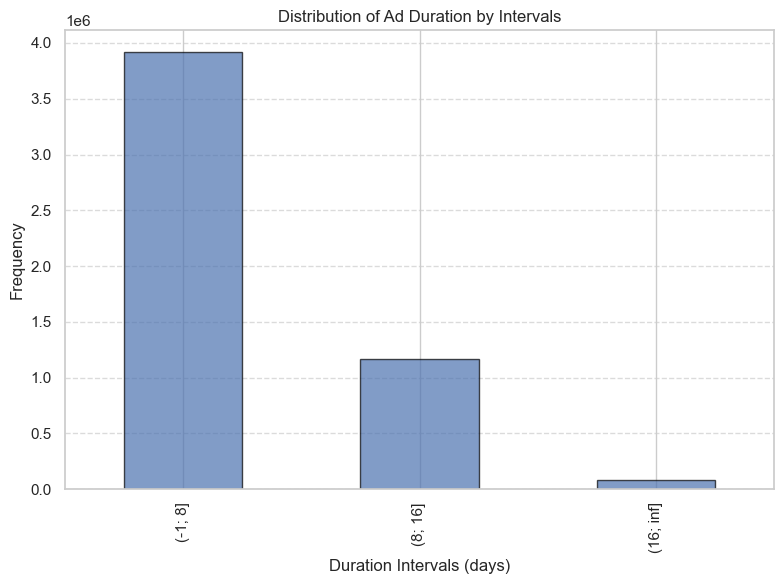

In [176]:
bins = [-1, 8, 16, float('inf')]
labels = ['(-1; 8]', '(8; 16]', '(16; inf]']

plt.figure(figsize=(8, 6))
pd.cut(data['duration'], bins=bins, labels=labels, include_lowest=True).value_counts(sort=False).plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Distribution of Ad Duration by Intervals")
plt.xlabel("Duration Intervals (days)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [262]:
data['ad_duration_power'] = pd.cut(
    data['duration'],
    bins=[-1, 8, 16, float('inf')],
    labels=[1, 2, 3],
).astype(int)

data['is_repeated_duration_ad'] = data['repeat_duration'].apply(lambda x: 0 if pd.isnull(x) else 1)

Применяя аналогичный процесс на общее количество объектов в лоте ( например лот - компьютеры, кол-во 100 ) имеем распределение которое можно выравнять, что может позитивно сказаться на общем качестве модели.

По итогам выравнивания, получили соотношение напоминающее экспоненциальное ( убывающее ). Далее заведем атрибут `total_count_bin` по аналогии с атрибутом `ad_duration_power`.

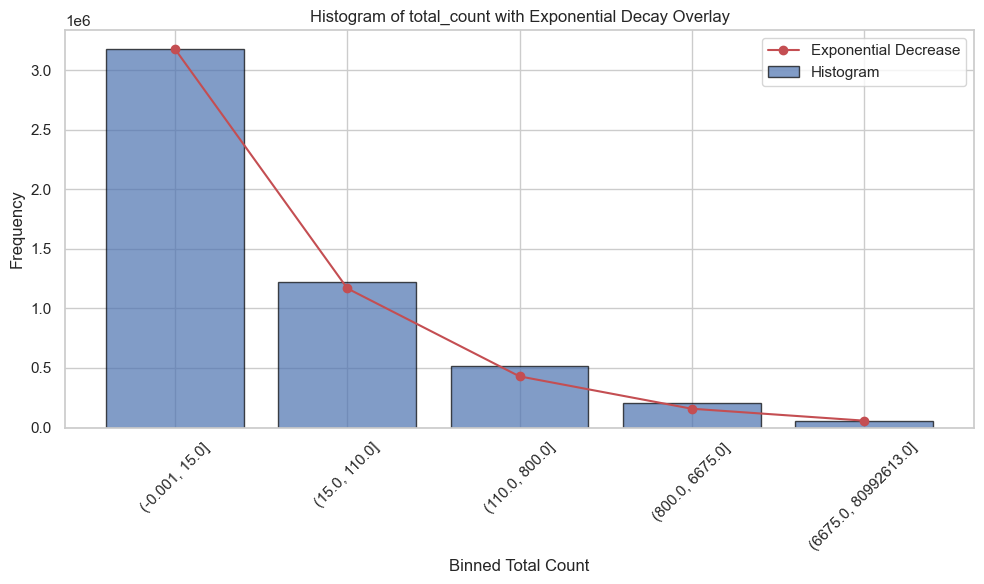

,Quantile,Bound
0.00,0.00,0.00
0.60,0.60,15.00
0.85,0.85,110.00
0.95,0.95,800.00
0.99,0.99,"6,675.00"
1.00,1.00,"80,992,613.00"


In [263]:
quantile_bins = np.unique(data['total_count'].quantile([0.0, 0.60, 0.85, 0.95, 0.99, 1]))
bin_counts = pd.cut(data['total_count'], bins=quantile_bins, include_lowest=True).value_counts(sort=False).reset_index()
bin_counts.columns = ['bin', 'count']

x = np.arange(len(bin_counts))
exp_decreasing = np.exp(-x)
exp_decreasing = exp_decreasing / exp_decreasing.max() * bin_counts['count'].max()  # Scale to match histogram

plt.figure(figsize=(10, 6))

plt.bar(
    bin_counts['bin'].astype(str), bin_counts['count'], edgecolor='black', alpha=0.7, label='Histogram'
)

plt.plot(
    bin_counts['bin'].astype(str), exp_decreasing, 'r-o', label='Exponential Decrease'
)

plt.xticks(rotation=45)
plt.title("Histogram of total_count with Exponential Decay Overlay")
plt.xlabel("Binned Total Count")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

pd.DataFrame({
    "Quantile": [0.0, 0.60, 0.85, 0.95, 0.99, 1],
    "Bound": data['total_count'].quantile([0.0, 0.60, 0.85, 0.95, 0.99, 1])
})

In [264]:
data['total_count_bin'] = pd.cut(
    data['total_count'],
    bins=quantile_bins,
    include_lowest=True, 
    labels=range(1, len(quantile_bins))
).astype(int) 

Переключившись на следующий атрибут `ad_trade_type_id` фактически означающий является ли данная закупка Первичной или Вторичной столкнулись с корявым заполнением поля. Однако, его все еще можно использовать, подготовив следующий словарь мы примерно поняли какие ID-шники что означают.

| **ID** | **Description**                     |
|--------|-------------------------------------|
| 1      | Первая закупка                     |
| 2      | Повторная закупка                  |
| 10     | Первая закупка                     |
| 11     | Повторная закупка                  |
| 0      | null                               |
| 21     | Первая закупка                     |
| 22     | Повторная закупка                  |
| 24     | Первая закупка                     |
| 25     | Повторная закупка                  |
| 3      | Первая закупка                     |
| 30     | Первая закупка                     |
| 32     | Первая закупка                     |
| 33     | Повторная закупка                  |
| 34     | Первая закупка                     |
| 35     | Повторная закупка                  |
| 39     | Первая закупка                     |
| 4      | Повторная закупка                  |
| 40     | Повторная закупка                  |
| 42     | Первая закупка                     |
| 44     | Повторная закупка с изменениями КД |
| 5      | Первая закупка                     |
| 52     | Первая закупка                     |
| 53     | Повторная закупка                  |
| 56     | Первая закупка                     |
| 57     | Повторная закупка                  |
| 6      | Повторная закупка                  |
| 60     | Первая закупка                     |
| 61     | Повторная закупка                  |
| 65     | Первая закупка                     |



Сразу напрашивается вопрос, какого черта тут происходит. Ответ оказался забавен, дело было в регистрах / пробелах и прочей мелочи, изначально поле было не выпадающим полем, а текстовым которое было нужно заполнять. Нам удалось связаться с разработчиками портала и ответили что можем позволить себе объединить ID по тексту.

Второе, что бросается в глаза, так это null - не совсем понятно к какому типу относится. Таких записей было совсем мало, их исключили, напоминает проблемы с заведением тендера.


In [268]:
data['ad_trade_type_id'] = data['ad_trade_type_id'].astype(int)
data = data[data.ad_trade_type_id != 0] # 16 rows
repeated_purchase_ids = [2, 11, 22, 25, 33, 35, 4, 40, 44, 53, 57, 6, 61]

In [271]:
data['is_repeated_ad'] = np.where(data['ad_trade_type_id'].isin(repeated_purchase_ids), 1, 0)

После этого мы изучили еще 4 атрибута, однако пришлось их все исключить по следующим причинам


<div style="font-family: Arial, sans-serif; text-align: center;">
<table style="width: 50%; margin: auto; bo rder-collapse: collapse; border: 1px solid black;">
  <thead>
    <tr style="background-color: #f2f2f2; border: 1px solid black;">
      <th style="padding: 8px; text-align: left;">Column</th>
      <th style="padding: 8px; text-align: left;">Column description</th>
      <th style="padding: 8px; text-align: left;">Why was excluded</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px; text-align: left;">psd_sign</td>
      <td style="padding: 8px; text-align: left;">Признак работы. 1-работа с ТЭО/ПСД, 2-работа на разработку ТЭО/ПСД</td>
      <td style="padding: 8px; text-align: left;">Не соответствует документации</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">single_org_sign</td>
      <td style="padding: 8px; text-align: left;">Закупки Единого организатора КГЗ МФ РК</td>
      <td style="padding: 8px; text-align: left;">Не соответствует документации</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">is_light_industry</td>
      <td style="padding: 8px; text-align: left;">Закупка легкой и мебельной промышленности</td>
      <td style="padding: 8px; text-align: left;">Поле особо не заполняется, оказывается бОльшая часть NaN, но также много и 0. Поле появилось не с даты старта портала и еще не успело набрать обороты</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">is_construction_work</td>
      <td style="padding: 8px; text-align: left;">Закупка с признаком СМР (строительно монтажных работ)</td>
      <td style="padding: 8px; text-align: left;">Согласно документации тут должны быть только значения 0 и 1, однако оказалось еще много совершенно левых значений ( 2, 3, 4). Мы не смогли их интерпретировать и поэтому не стали использовать</td>
    </tr>
  </tbody>
</table>
</div>

Следующий атрибут на очереди это `ad_subject_type_id` который буквально означает тип предоставляемых работ

| **ID** | **Description**       |
|--------|-----------------------|
| 1      | Товар (product)       |
| 2      | Работа (work)         |
| 3      | Услуга (service)      |


Здесь разметка 1 2 3 не имеет смысла (в отличии от длительности тендера), ведь с увеличением значения не факт что должно расти / падать или изменяться ценовое предложение следуя какой-либо вычурной функции. Из этого следует что, возможно, здесь может подойти one-hot encoding.

Один из атрибутов можно исключить, т.к этот атрибут можно выразить через другие два.



In [272]:
data['ad_subject_type_id'] = data['ad_subject_type_id'].astype(int)
data['is_subject_type_work'] = np.where(data['ad_subject_type_id'] == 2, 1, 0)
data['is_subject_type_service'] = np.where(data['ad_subject_type_id'] == 3, 1, 0)

Теперь можно проанализировать следующую группу переменных, оценим корреляцию и поймем какую из них стоит исключить. 

В случае с `quazi` мы не уверены означает ли nan признак что компания не является квази, поэтому исключили 73 записи.
Аналогичное касается и is_disable_person_advertisement, но слишком уж много `nan`, `0`, и слишком мало `1` ( около 20 тыс записей ). Спасибо, обойдемся без этой
самой переменной.



In [298]:
data = data[~data.participant_is_quazi.isna()]

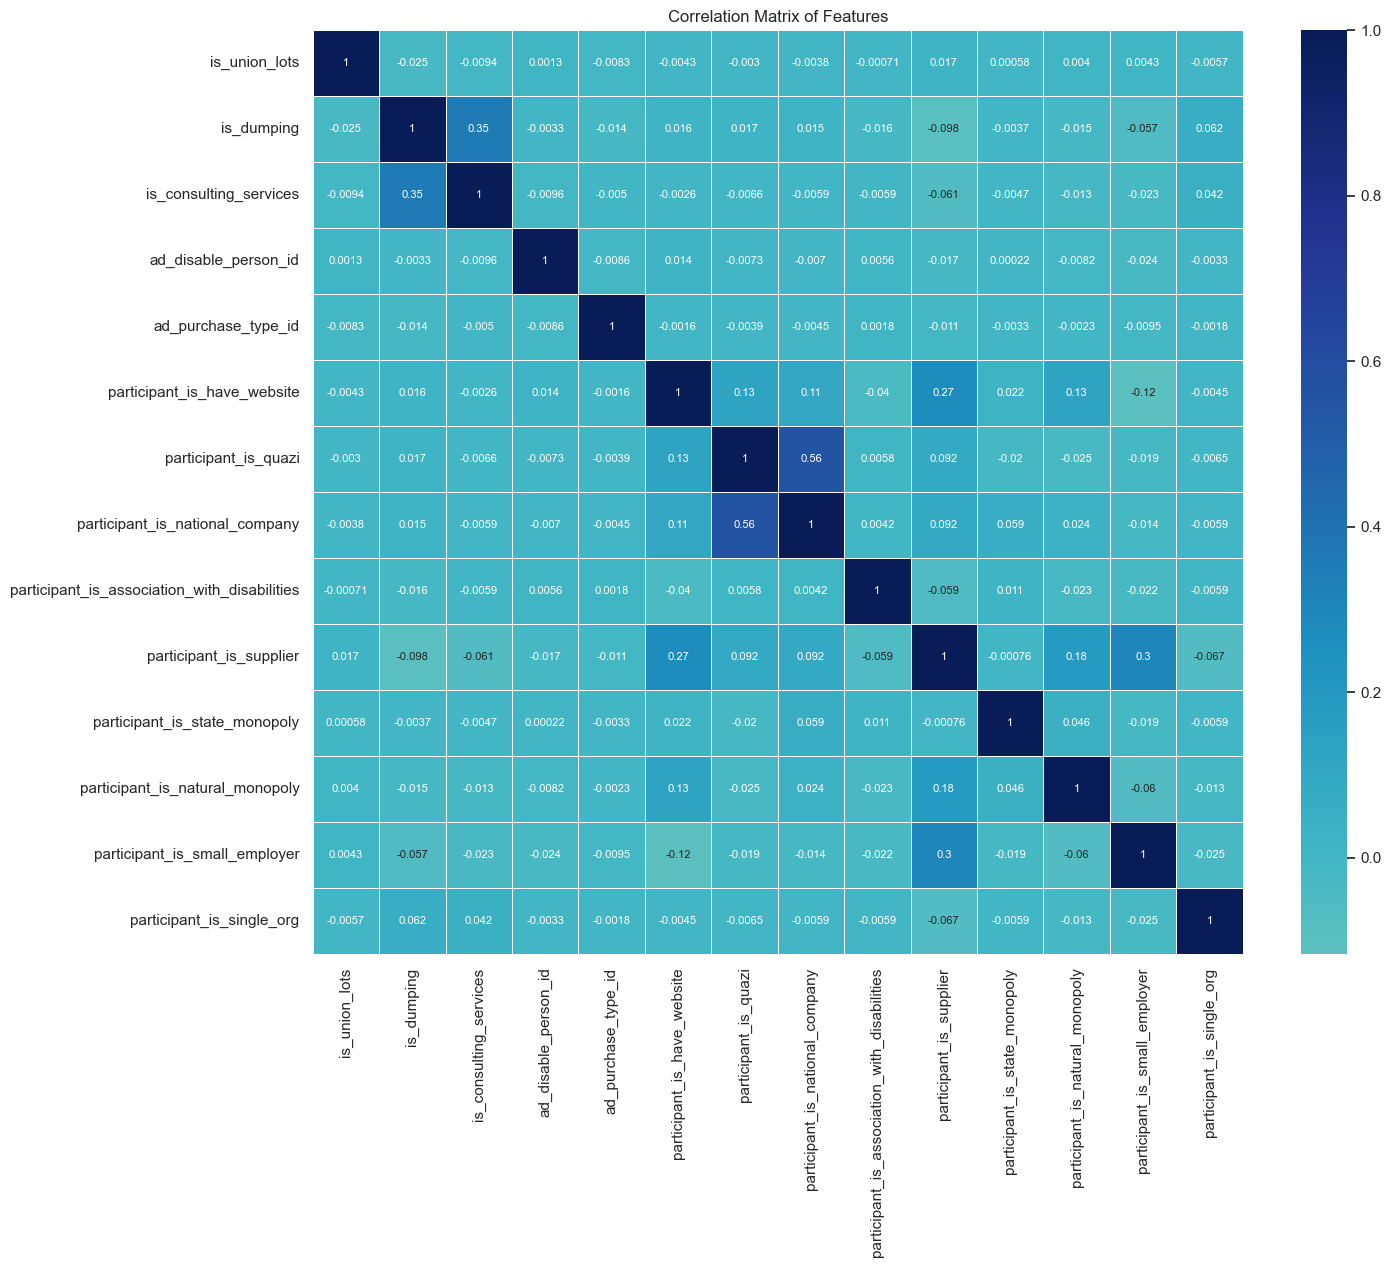

In [316]:
group_columns = [
    "is_union_lots",
    "is_dumping",
    "is_consulting_services",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_have_website",
    "participant_is_quazi",
    "participant_is_national_company",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
]
        
data[group_columns] = data[group_columns].astype(int)

plt.figure(figsize=(15, 12))

sns.heatmap(
    data[group_columns].dropna().corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.show()

Для тех переменных в которых мы не уверены / сомневаемся оставлять их или нет можем устроить другой тест, VIF (Variance Inflation Factor).
Возьмем переменные со средним и выше уровнем корреляции и оценим какие из них лучше исключить

In [326]:
columns_check_correlation = [
    'participant_is_national_company',
    'participant_is_quazi',
    'is_dumping',
    'participant_is_small_employer',
    'is_consulting_services',
    'participant_is_have_website',
    'participant_is_supplier'
]
vif_values = [
    variance_inflation_factor(data[columns_check_correlation].dropna().values, i) 
    for i in range(data[columns_check_correlation].shape[1])
]

for var, vif in zip(columns_check_correlation, vif_values):
    print(f"{var:30s}     {vif:5.2f}")

participant_is_national_company      1.48
participant_is_quazi                1.48
is_dumping                          1.17
participant_is_small_employer       1.33
is_consulting_services              1.15
participant_is_have_website         1.48
participant_is_supplier             1.85


И вот тут уже интересно, обычно считают значения размера 4 для VIF граничным когда стоит задуматься об исключении атрибутов.

Да, корреляция есть, но судя по VIF она не является большой. Поэтому, пока мы принимаем решение оставить атрибуты.

Переходя к следующей переменной, финансовым годам. По сути это поле означает на какие года размазана оплата. 

Учитывая что лет может быть несколько подряд, сам по себе год смысла не имеет, а вот продолжительность (насколько растянута оплата) - возможно имеет.
Конвертируем в вид 1/0, растянута ли оплата на несколько лет или только на 1.

In [327]:
data['is_multi_year'] = (data.ad_fin_years.apply(lambda x: x.split(":")).apply(lambda x: len(x)) > 1).astype(int)

Подготовив основные переменные, давайте накидаем простую линейную регрессию и посмотрим какие из переменных, возможно, не стат значимы. Исключив их перед тем как
скормить в бустинг.

Бустинг мы выбрали по нескольким причинам
1. У нас довольно большое количество бинарных и категориальных переменных
2. Оказалось проще и удобнее регулировать функцию потерь
3. Связь между total_amount и предиктором близка к линейной, с этим справляются неплохо бустинги ( если верить статьям ), ну и конечно линейные модели. Нейронки - оверхед, еще и обучение дольше идти будет. Плюс мы немного начали переживать за переобучение

In [347]:
columns_to_take = [
    "total_amount",
    "ad_duration_power",
    "is_repeated_duration_ad",
    "total_count_bin",
    "is_repeated_ad",
    "is_subject_type_work",
    "is_subject_type_service",
    "is_union_lots",
    "is_dumping",
    "is_consulting_services",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_have_website",
    "participant_is_quazi",
    "participant_is_national_company",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
    "is_multi_year",
]


X = data[columns_to_take].copy()
X['total_amount'] = np.log2(X['total_amount'])


y = data["sw_total_price_wdiscount"]
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# sw_total_price_wdiscount

In [348]:
import statsmodels.api as sm


X_train_with_intercept = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_intercept).fit()

summary_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(X_train.columns),
    "Coefficient": model.params.values,
    "P-Value": model.pvalues.values,
    "Standard Error": model.bse.values
})

# for interpretability
summary_df["Absolute Contribution"] = abs(summary_df["Coefficient"])

summary_df = summary_df.sort_values(by="Absolute Contribution", ascending=False).reset_index(drop=True)

y_pred = model.predict(sm.add_constant(X_test))

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

summary_df

,Feature,Coefficient,P-Value,Standard Error,Absolute Contribution
0,total_amount,0.98,0.00,0.00,0.98
1,is_repeated_ad,0.23,0.00,0.00,0.23
2,is_dumping,0.18,0.00,0.00,0.18
3,ad_purchase_type_id,0.17,0.00,0.00,0.17
4,is_repeated_duration_ad,0.08,0.00,0.00,0.08
5,Intercept,-0.07,0.00,0.00,0.07
6,is_subject_type_service,-0.07,0.00,0.00,0.07
7,is_union_lots,0.06,0.00,0.00,0.06
8,participant_is_quazi,0.05,0.00,0.00,0.05
9,ad_disable_person_id,0.05,0.00,0.00,0.05


Смотрим на p-value, как пример возьмем confidence interval 95% => исключим переменные со значением выше `0.05`.

Таким образом, прощайте
1. participant_is_national_company
2. is_consulting_services
3. is_multi_year
4. participant_is_have_website

Ну и перепрогоним еще разок

In [389]:
columns_to_take = [
    "total_amount",
    "ad_duration_power",
    "is_repeated_duration_ad",
    "total_count_bin",
    "is_repeated_ad",
    "is_subject_type_work",
    "is_subject_type_service",
    "is_union_lots",
    "is_dumping",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_quazi",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
]

X = data[columns_to_take].copy()
X['total_amount'] = np.log2(X['total_amount'])

# y = data[np.log2(data["total_amount"]) <= 24.84]["sw_total_price_wdiscount"]
y = data["sw_total_price_wdiscount"]
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


X_train_with_intercept = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_with_intercept).fit()

summary_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(X_train.columns),
    "Coefficient": model.params.values,
    "P-Value": model.pvalues.values,
    "Standard Error": model.bse.values
})

# for interpretability
summary_df["Absolute Contribution"] = abs(summary_df["Coefficient"])

summary_df = summary_df.sort_values(by="Absolute Contribution", ascending=False).reset_index(drop=True)

y_pred = model.predict(sm.add_constant(X_test))

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

summary_df

,Feature,Coefficient,P-Value,Standard Error,Absolute Contribution
0,total_amount,0.98,0.00,0.00,0.98
1,is_repeated_ad,0.23,0.00,0.00,0.23
2,is_dumping,0.18,0.00,0.00,0.18
3,ad_purchase_type_id,0.17,0.00,0.00,0.17
4,is_repeated_duration_ad,0.08,0.00,0.00,0.08
5,Intercept,-0.07,0.00,0.00,0.07
6,is_subject_type_service,-0.07,0.00,0.00,0.07
7,is_union_lots,0.06,0.00,0.00,0.06
8,participant_is_quazi,0.05,0.00,0.00,0.05
9,ad_disable_person_id,0.05,0.00,0.00,0.05


In [390]:
# mse, r2, np.sqrt(mse), mean_absolute_error(np.power(2, y_test), np.power(2, y_pred))

# (np.int64(358119), np.float64(35.012494720540616), 123810.45023454943)

(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test), np.power(2, y_pred))

(np.int64(203976), np.float64(39.486078551697034), 500916.7609689238)

Теперь, прежде чем двигаться в сторону бустинга, давайте определим функцию потерь и требования к ней. Основное и самое важное, нам важно чтобы residuals в основном были НИЖЕ таргета. 
Ибо в случае если мы предсказываем таргет выше реального - мы проигрываем сделку. Это означает что нам лучше немного недозаработать, но не проиграть.

Таким образом, наша функция потерь может быть объявлена как

$$
\text{overprice\_watchdog}(y_{\text{pred}}, d_{\text{train}}) =
\begin{cases} 
    \text{Gradient} =
    \begin{cases} 
        2 \alpha (y_{\text{pred}} - y_{\text{true}}), & \text{if } y_{\text{pred}} > y_{\text{true}} \\
        2 (1 - \alpha) (y_{\text{pred}} - y_{\text{true}}), & \text{otherwise}
    \end{cases} \\[1em]
    \text{Hessian} =
    \begin{cases} 
        2 \alpha, & \text{if } y_{\text{pred}} > y_{\text{true}} \\
        2 (1 - \alpha), & \text{otherwise}
    \end{cases}
\end{cases}
$$


Где 

- $y_{\text{pred}}$ - наши сделанные предикты
- $y_{\text{true}}$ - реальные значения
- $\alpha$ - а это наш любимый регуляризатор. Чем он больше - тем сильнее мы пинаем за предикты выше нужного значения

$\text{Gradient}$ же и $\text{Hessian}$ это наши первая и вторая производные, которые часто в градиенте используются.

Мы немного поэкспериментировали и нашли оптимальным $\alpha$ на уровне $0.4$

In [363]:
def overprice_watchdog(y_pred, dtrain):
    y_true = dtrain.get_label()
    residual = y_pred - y_true

    alpha = 0.4
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))

    return gradient, hessian

Немного детальнее изучив наши данные, и обращая внимание на разброс, мы решили выкинуть аутлайеры которые тянут в нехорошую сторону нашу модель.

Выбросить небольшой процент аутлайеров.

In [391]:
X = data[np.log2(data["total_amount"]) <= 22.17][columns_to_take].copy()
X['total_amount'] = np.log2(X['total_amount'])

y = data[np.log2(data["total_amount"]) <= 22.17]["sw_total_price_wdiscount"]
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

[0]	train-rmse:14.83075	train-custom_rmse:14.83075	test-rmse:14.83701	test-custom_rmse:14.83701
[1]	train-rmse:14.08967	train-custom_rmse:14.08967	test-rmse:14.09564	test-custom_rmse:14.09564
[2]	train-rmse:13.38567	train-custom_rmse:13.38567	test-rmse:13.39136	test-custom_rmse:13.39136
[3]	train-rmse:12.71689	train-custom_rmse:12.71689	test-rmse:12.72232	test-custom_rmse:12.72232
[4]	train-rmse:12.08158	train-custom_rmse:12.08158	test-rmse:12.08675	test-custom_rmse:12.08675
[5]	train-rmse:11.47806	train-custom_rmse:11.47805	test-rmse:11.48299	test-custom_rmse:11.48299
[6]	train-rmse:10.90474	train-custom_rmse:10.90474	test-rmse:10.90944	test-custom_rmse:10.90944
[7]	train-rmse:10.36011	train-custom_rmse:10.36011	test-rmse:10.36460	test-custom_rmse:10.36459
[8]	train-rmse:9.84275	train-custom_rmse:9.84275	test-rmse:9.84703	test-custom_rmse:9.84703
[9]	train-rmse:9.35129	train-custom_rmse:9.35129	test-rmse:9.35536	test-custom_rmse:9.35536
[10]	train-rmse:8.88444	train-custom_rmse:8.8844

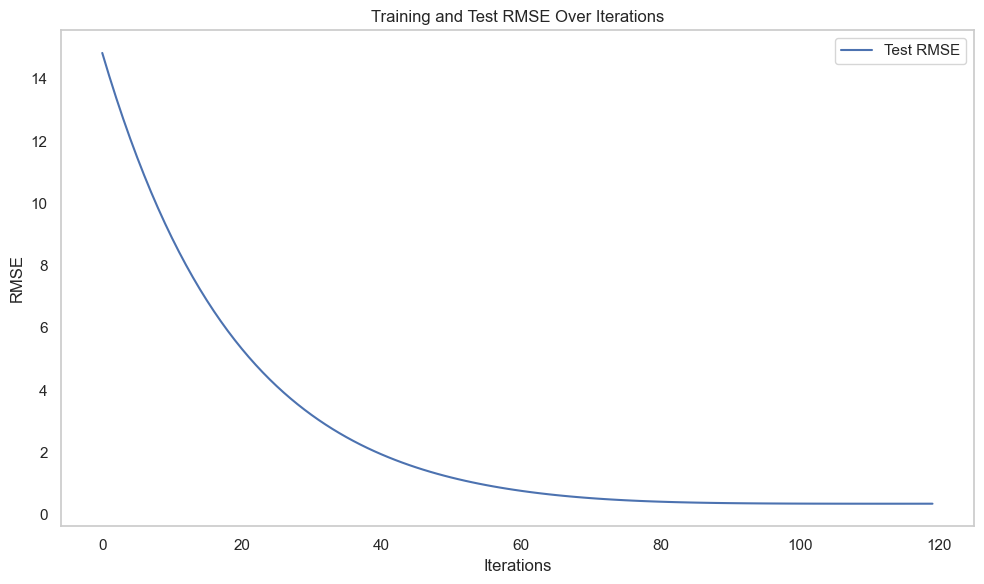

In [393]:
def custom_rmse(y_pred, dtrain):
    y_true = dtrain.get_label()
    # y_pred = np.power(2, y_pred) + 1
    # y_true = np.power(2, y_true) + 1

    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return "custom_rmse", rmse


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evals_result = {}

params = {
    "learning_rate": 0.05,
    "max_depth": 10,
    "random_state": 42,
}

evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=120,
    obj=overprice_watchdog,
    custom_metric=custom_rmse,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=True
)

y_pred = model.predict(dtest)

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
print(f"R2 Score: {r2}")


plt.figure(figsize=(10, 6))
plt.plot(evals_result['test']['custom_rmse'], label='Test RMSE',)
plt.title("Training and Test RMSE Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [394]:
# (np.int64(358119), np.float64(35.012494720540616), 123810.45023454943)
(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test), np.power(2, y_pred))

(np.int64(200571), np.float64(40.87271586094746), 47394.97176855187)

Результат уже неплохой, но насколько неплохой? 

Давайте проверим

In [400]:
xgb_summary = data.loc[y_test.index]
xgb_summary["base_prediction"] = np.power(2, y_pred) + 1
xgb_summary = xgb_summary[["fw_total_price_wdiscount", "base_prediction", "sw_total_price_wdiscount", "total_amount"]]
xgb_summary['after_prediction_unearned_revenue'] = xgb_summary.apply(
    lambda row: min(row['sw_total_price_wdiscount'], row['sw_total_price_wdiscount'] - row['base_prediction'])
    if row['base_prediction'] > row['sw_total_price_wdiscount'] else row['sw_total_price_wdiscount'] - row['base_prediction'],
    axis=1
)

quantile_values = xgb_summary['total_amount'].quantile(quantiles)
cumulative_lots = [xgb_summary['total_amount'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

xgb_summary['unearned_revenue'] = xgb_summary['sw_total_price_wdiscount'] - xgb_summary['fw_total_price_wdiscount']
xgb_summary['unearned_revenue_pct'] = (xgb_summary['sw_total_price_wdiscount'] / xgb_summary['fw_total_price_wdiscount'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0
after_predictions_unearned_revenue = []

for start, end in zip(range_start, range_end):
    unearned_sum = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)
    
    after_predictions_sum = xgb_summary[(xgb_summary['total_amount'] > start) & (xgb_summary['total_amount'] <= end)]['after_prediction_unearned_revenue'].sum()
    after_predictions_unearned_revenue.append(after_predictions_sum)
    
unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct,
    "AfterPredictionUnearnedRevenue": after_predictions_unearned_revenue
})
unearned_revenue_summary["UnearnedRevenueRatioDecrease"] = np.where(unearned_revenue_summary["AfterPredictionUnearnedRevenue"] < 0, 0, (1 - unearned_revenue_summary["AfterPredictionUnearnedRevenue"] / unearned_revenue_summary["UnearnedRevenue"]) * 100)


unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent,AfterPredictionUnearnedRevenue,UnearnedRevenueRatioDecrease
0.00,0.00,"1,455.36",1,1,13.00,13.00,0.90,-251.31,0.00
0.01,0.01,"2,410.71",4939,4938,"771,516.90","771,529.90",10.11,"54,976.49",92.87
0.05,0.05,"4,710.00",24537,19598,"7,664,922.31","8,436,452.21",16.82,"502,177.63",93.45
0.10,0.10,"7,700.00",49136,24599,"16,887,346.12","25,323,798.33",17.65,"1,196,839.62",92.91
0.25,0.25,"20,400.00",122799,73663,"101,910,661.94","127,234,460.27",16.36,"9,965,514.18",90.22
0.50,0.50,"74,181.00",245361,122562,"448,140,041.04","575,374,501.31",13.94,"59,741,696.18",86.67
0.75,0.75,"279,000.00",368042,122681,"1,410,244,269.19","1,985,618,770.50",12.20,"272,711,482.51",80.66
0.90,0.90,"916,976.76",441649,73607,"2,603,438,469.02","4,589,057,239.52",11.02,"655,408,245.31",74.83
0.95,0.95,"1,774,660.00",466185,24536,"2,011,234,239.76","6,600,291,479.28",9.93,"553,984,086.80",72.46
0.99,0.99,"3,680,000.00",485815,19630,"3,042,682,686.49","9,642,974,165.77",9.09,"972,074,492.19",68.05


Ну вы только посмотрите на эту сигму.

Да, мы плохо справились для одного лота ценой 1455, но все остальные лоты улучшили.
Значения стоит интерпретировать так - $80.66$ для лотов суммой до $279,000$ означает что закупщики смогут заработать $80.66 / 100%$ от всего объема недополученной ранее прибыли для лотов ценой от $74,181$ до $279,000$ благодаря нашей модели

Осталось решить проблему с процентом побед, и для этого нам могут неплохо помочь многорукие бандиты. 

Раз у нас есть проблема с оверпредиктами, ну так давайте будем следуя вероятностному распределению снижать на определенный процент наш предикт, чтобы максимизировать не профит, а шанс победы.

Разумеется, с ручками гадать не хочется, так давайте оценим какие ручки ( сброс на какой процент предикта ) будет иметь смысл. Сделать это довольно просто, можем прогнать модель и сделать предикт 
с поправкой на мультипликатор.

In [403]:
for i in np.arange(0.01, 1.01, 0.01):
    ((y_pred * i > y_test).sum() / len(y_test)) * 100


_results = []

# Iterate through multipliers and compute the percentage of over-predictions
for i in np.arange(0.01, 1.01, 0.01):
    over_prediction_percentage = (y_pred * i > y_test).sum() / len(y_test) * 100
    _results.append({"multiplier": i, "over_prediction_percent": over_prediction_percentage})

pd.DataFrame(_results).sort_values(by="over_prediction_percent", ascending=False).head(12)

,multiplier,over_prediction_percent
99,1.00,40.87
98,0.99,27.92
97,0.98,18.78
96,0.97,12.18
95,0.96,7.19
94,0.95,3.82
93,0.94,1.77
92,0.93,0.69
91,0.92,0.23
90,0.91,0.08


Ну вот мы и видим как меняется процент побед при снижении предикта на определенный процент.

Нам нужны не только ручки, но и механика определения ЛУЧШЕЙ.

Нам критически важно чтобы предикты были между первым и вторым победителем, а иначе мы либо потеряем прибыль, либло проиграем тендер.

В таком случае нашу функцию `choose_best_arm`, которая выбирает лучшую ручку, можно описать следующим образом

$$
\text{choose\_best\_arm}(\text{predictions}, \text{fw\_price}, \text{sw\_price}, \text{total\_amount}) =
\begin{cases}
    \text{Шаг 1: Фильтруем предсказания в пределах } [fw\_price, sw\_price], \\
    \text{Шаг 2: Выбираем предсказание, ближайшее к } sw\_price, & \text{если существуют подходящие после шага 1} \\
    \text{Шаг 3: Если не прокатило — делаем предикт ближайший к} \leq sw\_price \\
    \text{Шаг 4: Наша последняя надежда — предсказание, ближайшее к total\_amount}
\end{cases}
$$

Или же, можно описать так
$$ \text{valid\_predictions} = \{p \in \text{predictions} : fw\_price < p < sw\_price\} $$

$$ \text{closest\_prediction} = \max(\text{valid\_predictions}) $$

Если подходящих предсказаний нет то 
$$ \text{fallback\_predictions} = \{p \in \text{predictions} : p \leq sw\_price\} $$
$$ \text{closest\_prediction} = \max(\text{fallback\_predictions}) $$


Ну и если ничего под критерии не подошло, то аппроксимируем к `total_amount`
$$ \text{closest\_prediction} = \arg\min_{p \in \text{predictions}} |\text{total\_amount} - p| $$


Среди аргументов функции
- `predictions` - предикты
- `fw_price` - нижняя граница, первый победитель
- `sw_price` - верхняя граница, второй победитель
- `total_amount` - изначальная цена лота


In [405]:
# def choose_best_arm(predictions, true_value):
def choose_best_arm(predictions, fw_price, sw_price, total_amount):
    """
        Select the best arm based on predictions being:
        1. Closest to sw_price.
        2. Within the range [fw_price, sw_price].
        3. Not deviating excessively from total_amount.
    """

    # Step 1 - filter predictions within [fw_price, sw_price]
    valid_predictions = [pred for pred in predictions if fw_price < pred < sw_price]

    # Step 2 - among valid predictions, prefer the one closest to sw_price
    if valid_predictions:
        closest_prediction = max(valid_predictions)  # Closest to sw_price
    else:
        # fallback - choose prediction closest to sw_price but <= sw_price
        fallback_predictions = [pred for pred in predictions if pred < sw_price]
        if fallback_predictions:
            closest_prediction = max(fallback_predictions)
        else:
            # last chance - choose prediction closest to total_amount
            closest_prediction = min(predictions, key=lambda x: abs(x - total_amount))

    return predictions.index(closest_prediction)

# pricing strategies
pricing_strategies = [0.89, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
n_arms = len(pricing_strategies)
successes = [0] * n_arms
failures = [0] * n_arms

results = []

fw_prices = data['fw_total_price_wdiscount'].loc[X_test.index]
sw_prices = data['sw_total_price_wdiscount'].loc[X_test.index]
initial_lot_prices = data['total_amount'].loc[X_test.index]

for i in range(len(X_test)):
    if i % 10_000 == 0:
        print(i)
    if i == 100_000:
        break

    single_row = X_test.iloc[i:i + 1]
    dmatrix_input = xgb.DMatrix(single_row)

    base_prediction = np.power(2, model.predict(dmatrix_input)[0]) + 1

    # Adjust predictions using all strategies
    adjusted_predictions = [base_prediction * multiplier for multiplier in pricing_strategies]

    fw_price = fw_prices.iloc[i]
    sw_price = sw_prices.iloc[i]
    total_amount = X_test.iloc[i]["total_amount"] 

    chosen_arm = choose_best_arm(adjusted_predictions, fw_price, sw_price, total_amount)


    # Final adjusted prediction using the chosen arm
    adjusted_prediction = adjusted_predictions[chosen_arm]

    reward = 1 if fw_price < adjusted_prediction < sw_price else 0
    
    # Determine if the chosen prediction is rewarded
    # reward = 1 if adjusted_prediction <= true_value else 0

    if reward:
        successes[chosen_arm] += adjusted_prediction / sw_price
    else:
        failures[chosen_arm] += 1

    results.append({
        # "true_value": true_value,
        "first_winner_price": fw_price,
        "base_prediction": base_prediction,
        "adjusted_prediction": adjusted_prediction,
        "second_winner_price": sw_price,
        "initial_lot_price": initial_lot_prices.iloc[i],
        "chosen_arm": chosen_arm,
        "reward": reward
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.head()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


,first_winner_price,base_prediction,adjusted_prediction,second_winner_price,initial_lot_price,chosen_arm,reward
0,"9,850.00","8,913.48","8,913.48","10,000.00","10,491.05",10,0
1,"33,748.00","44,329.05","39,452.85","37,648.00","62,400.00",0,0
2,"173,100.00","140,921.94","140,921.94","180,000.00","187,500.00",10,0
3,"42,000.00","45,984.77","44,605.23","45,000.00","60,000.00",7,1
4,"1,835,981.00","1,666,545.50","1,666,545.50","1,836,234.00","2,151,785.72",10,0


In [409]:
def thompson_sampling_bandit(n_arms, successes, failures):
    sampled_values = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(n_arms)]
    return np.argmax(sampled_values)

thompson_sampling_bandit(len(pricing_strategies), successes, failures), successes, failures
# choose_best_arm([168_651.94])

(np.int64(1),
 [np.float64(2011.1025781809026),
  np.float64(1033.4589291318077),
  np.float64(1135.9392972086116),
  np.float64(1142.9626863907138),
  np.float64(1104.3118879360584),
  np.float64(1170.020496482379),
  np.float64(1151.0611687263192),
  np.float64(1212.8936434703073),
  np.float64(1141.3160873208412),
  np.float64(1294.5056805271795),
  np.float64(19173.621622464038)],
 [27464, 88, 99, 73, 96, 103, 95, 92, 126, 113, 37982])

In [408]:
# xgb_summary = data.loc[y_test.index]
# xgb_summary["base_prediction"] = np.power(2, y_pred) + 1
# xgb_summary = xgb_summary[["fw_total_price_wdiscount", "base_prediction", "sw_total_price_wdiscount", "total_amount"]]
# xgb_summary['after_prediction_unearned_revenue'] = xgb_summary.apply(
#     lambda row: min(row['sw_total_price_wdiscount'], row['sw_total_price_wdiscount'] - row['base_prediction'])
#     if row['base_prediction'] > row['sw_total_price_wdiscount'] else row['sw_total_price_wdiscount'] - row['base_prediction'],
#     axis=1
# )

results_df['after_prediction_unearned_revenue'] = results_df.apply(
    lambda row: min(row['second_winner_price'], row['second_winner_price'] - row['adjusted_prediction'])
    if row['adjusted_prediction'] > row['second_winner_price'] else row['second_winner_price'] - row['adjusted_prediction'],
    axis=1
)

quantile_values = results_df['initial_lot_price'].quantile(quantiles)
cumulative_lots = [results_df['initial_lot_price'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

results_df['unearned_revenue'] = results_df['second_winner_price'] - results_df['first_winner_price']
results_df['unearned_revenue_pct'] = (results_df['second_winner_price'] / results_df['first_winner_price'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0
after_predictions_unearned_revenue = []

for start, end in zip(range_start, range_end):
    unearned_sum = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)
    
    after_predictions_sum = results_df[(results_df['initial_lot_price'] > start) & (results_df['initial_lot_price'] <= end)]['after_prediction_unearned_revenue'].sum()
    after_predictions_unearned_revenue.append(after_predictions_sum)

    
unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct,
    "AfterPredictionUnearnedRevenue": after_predictions_unearned_revenue
})
unearned_revenue_summary["UnearnedRevenueRatioDecrease"] = (1 - unearned_revenue_summary["AfterPredictionUnearnedRevenue"] / unearned_revenue_summary["CumulativeUnearnedRevenue"]) * 100

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent,AfterPredictionUnearnedRevenue,UnearnedRevenueRatioDecrease
0.00,0.00,"1,462.00",1,1,0.00,0.00,0.00,-51.69,inf
0.01,0.01,"2,410.71",1004,1003,"161,942.76","161,942.76",10.30,"62,568.06",61.36
0.05,0.05,"4,750.00",5018,4014,"1,561,414.89","1,723,357.65",16.47,"472,289.95",72.59
0.10,0.10,"7,857.12",10000,4982,"3,415,365.71","5,138,723.36",17.40,"1,102,100.41",78.55
0.25,0.25,"20,784.00",25001,15001,"21,356,204.85","26,494,928.21",16.67,"8,117,135.89",69.36
0.50,0.50,"75,000.00",50482,25481,"94,621,896.82","121,116,825.03",14.00,"47,162,029.78",61.06
0.75,0.75,"281,250.22",75000,24518,"289,527,228.58","410,644,053.61",12.14,"176,115,197.62",57.11
0.90,0.90,"937,500.00",90007,15007,"541,732,319.37","952,376,372.98",10.94,"375,445,346.31",60.58
0.95,0.95,"1,785,714.29",95012,5005,"416,271,608.90","1,368,647,981.88",10.13,"296,694,506.69",78.32
0.99,0.99,"3,770,553.57",99000,3988,"626,587,017.03","1,995,234,998.91",9.02,"527,867,519.77",73.54


And we did it! we increase our chances to win.

All links to our materials are available at the top or follow that [link](https://github.com/savoskin0502/public-procurement-optimization)
Our site is accessible via [api](https://pricing-kbtu.streamlit.app/)

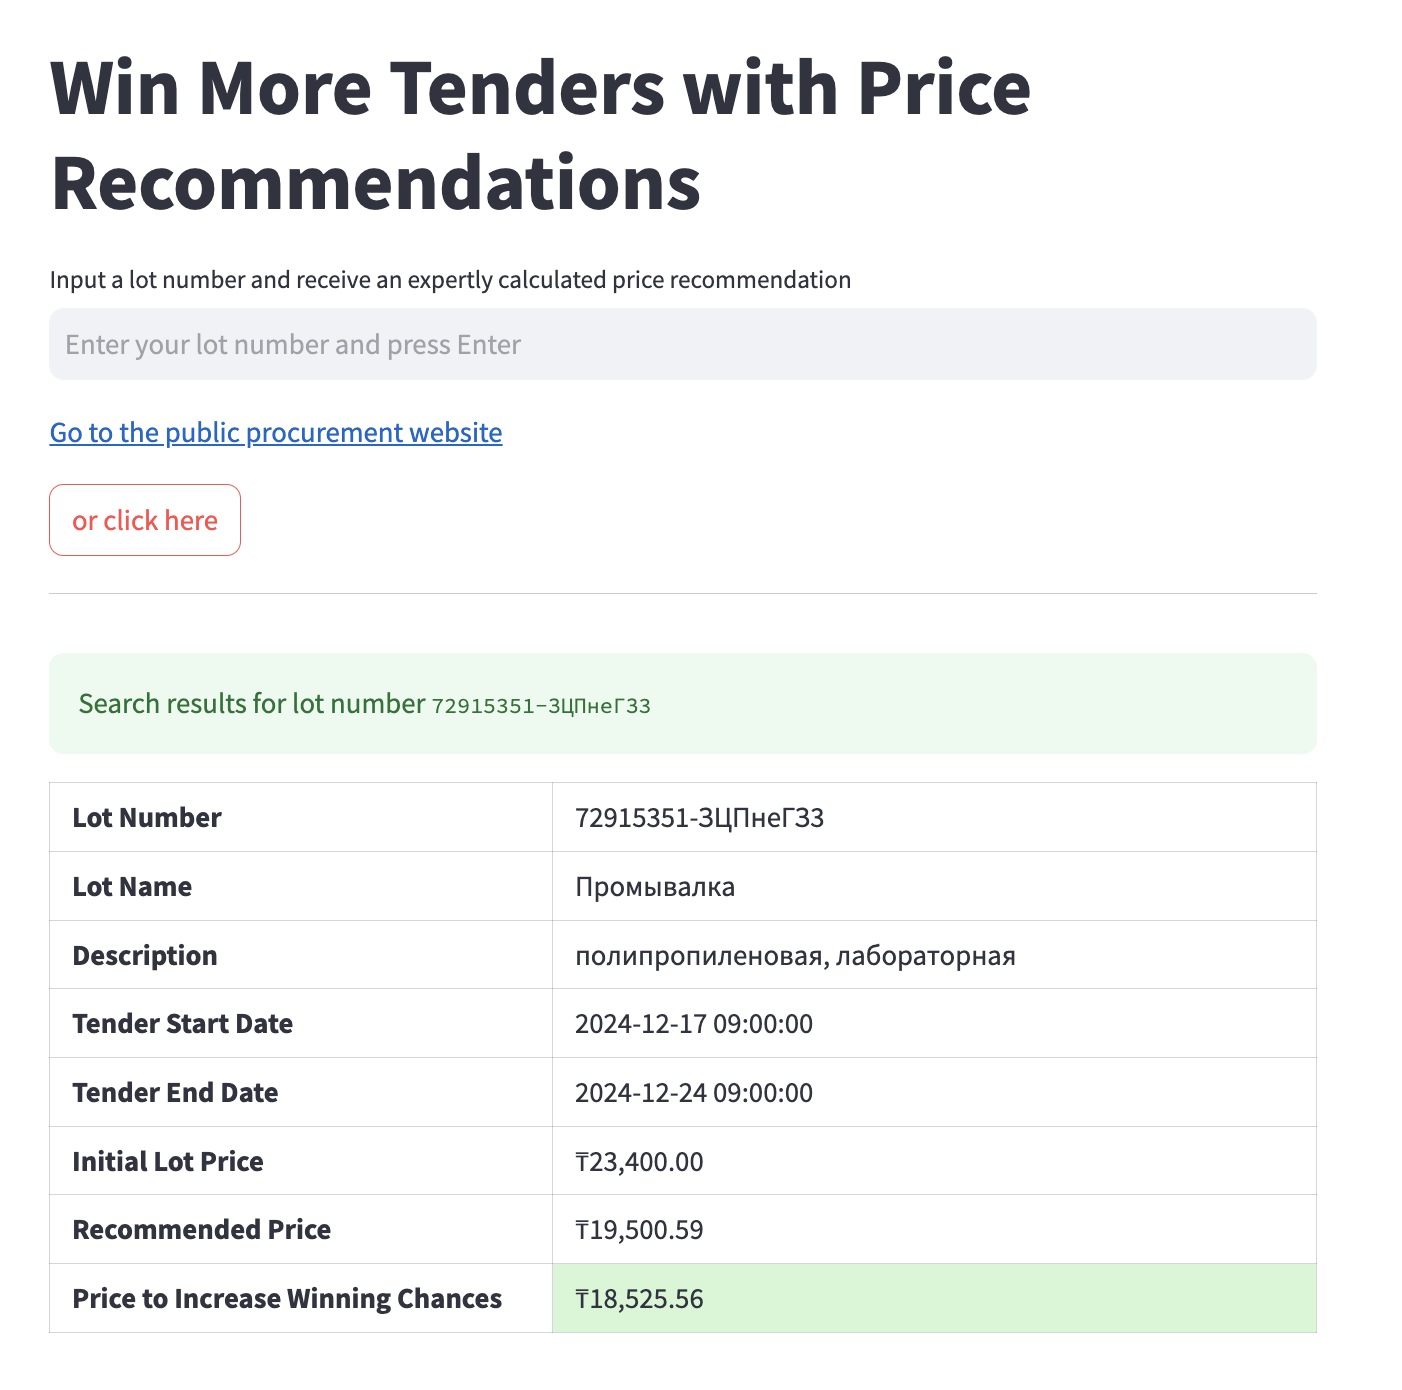